Pratham Tiwari Big Data Project

1.Spark Setup and Data Extraction

In [ ]:
import pyspark
spark = pyspark.sql.SparkSession.builder.appName("Pratham Big Data Project").getOrCreate()

sc = spark.sparkContext

In [ ]:
df = spark.read.csv("train.csv", header=True, inferSchema=True)
df.show(5)

+-------------------+--------------+--------------------+---------+----------+--------------+--------------------+-------------------+------------------+
|              Dates|      Category|            Descript|DayOfWeek|PdDistrict|    Resolution|             Address|                  X|                 Y|
+-------------------+--------------+--------------------+---------+----------+--------------+--------------------+-------------------+------------------+
|2015-05-13 23:53:00|      WARRANTS|      WARRANT ARREST|Wednesday|  NORTHERN|ARREST, BOOKED|  OAK ST / LAGUNA ST|  -122.425891675136|  37.7745985956747|
|2015-05-13 23:53:00|OTHER OFFENSES|TRAFFIC VIOLATION...|Wednesday|  NORTHERN|ARREST, BOOKED|  OAK ST / LAGUNA ST|  -122.425891675136|  37.7745985956747|
|2015-05-13 23:33:00|OTHER OFFENSES|TRAFFIC VIOLATION...|Wednesday|  NORTHERN|ARREST, BOOKED|VANNESS AV / GREE...|   -122.42436302145|  37.8004143219856|
|2015-05-13 23:30:00| LARCENY/THEFT|GRAND THEFT FROM ...|Wednesday|  NORTHER

In [ ]:
from pyspark.sql.functions import col, lower

df = spark.read.format('csv')\
    .option('header', 'true')\
    .option('inferSchema', 'true')\
    .load('train.csv')

data = df.select(
    lower(col('Category')).alias('Category'),
    lower(col('Descript')).alias('Description')
)

data.cache()

print('Dataframe Structure')
print('----------------------------------')
data.printSchema()

print('\nDataframe preview')
print('----------------------------------')
data.show(5)

print('\nTotal number of rows:', df.count())

Dataframe Structure
----------------------------------
root
 |-- Category: string (nullable = true)
 |-- Description: string (nullable = true)


Dataframe preview
----------------------------------
+--------------+--------------------+
|      Category|         Description|
+--------------+--------------------+
|      warrants|      warrant arrest|
|other offenses|traffic violation...|
|other offenses|traffic violation...|
| larceny/theft|grand theft from ...|
| larceny/theft|grand theft from ...|
+--------------+--------------------+
only showing top 5 rows


Total number of rows: 878049


In [ ]:
from pyspark.sql.functions import col

def top_n_list(df, var, N):

    total_unique = df.select(var).distinct().count()
    print(f"Total number of unique values in '{var}': {total_unique}\n")
    print(f"Top {N} most frequent values in '{var}':")

    df.groupBy(var).count()\
      .withColumnRenamed('count', 'totalValue')\
      .orderBy(col('totalValue').desc())\
      .show(N, truncate=False)

top_n_list(data, 'Category', 10)
print('\n')
top_n_list(data, 'Description', 10)

Total number of unique values in 'Category': 39

Top 10 most frequent values in 'Category':
+--------------+----------+
|Category      |totalValue|
+--------------+----------+
|larceny/theft |105016    |
|other offenses|72058     |
|non-criminal  |56219     |
|assault       |42685     |
|drug/narcotic |27184     |
|vandalism     |25558     |
|warrants      |22083     |
|vehicle theft |20012     |
|burglary      |19567     |
|suspicious occ|18860     |
+--------------+----------+
only showing top 10 rows



Total number of unique values in 'Description': 856

Top 10 most frequent values in 'Description':
+-------------------------------------+----------+
|Description                          |totalValue|
+-------------------------------------+----------+
|grand theft from locked auto         |37291     |
|drivers license, suspended or revoked|15913     |
|lost property                        |15786     |
|battery                              |13879     |
|aided case, mental disturbed   

In [ ]:
data.select('Category').distinct().count()

39

In [ ]:
training, test = data.randomSplit([0.7,0.3], seed=60)
print("Training Dataset Count:", training.count())
print("Test Dataset Count:", test.count())

Training Dataset Count: 343261
Test Dataset Count: 146844


2.Pipeline Setup and Model Definition

In [ ]:
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer, OneHotEncoder, StringIndexer, VectorAssembler, HashingTF, IDF, Word2Vec
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, NaiveBayes

regex_tokenizer = RegexTokenizer(pattern='\\W')\
                  .setInputCol("Description")\
                  .setOutputCol("tokens")

extra_stopwords = ['http','amp','rt','t','c','the']
stopwords_remover = StopWordsRemover()\
                    .setInputCol('tokens')\
                    .setOutputCol('filtered_words')\
                    .setStopWords(extra_stopwords)


count_vectors = CountVectorizer(vocabSize=10000, minDF=5)\
               .setInputCol("filtered_words")\
               .setOutputCol("features")


hashingTf = HashingTF(numFeatures=10000)\
            .setInputCol("filtered_words")\
            .setOutputCol("raw_features")

idf = IDF(minDocFreq=5)\
        .setInputCol("raw_features")\
        .setOutputCol("features")

word2Vec = Word2Vec(vectorSize=1000, minCount=0)\
           .setInputCol("filtered_words")\
           .setOutputCol("features")

label_string_idx = StringIndexer()\
                  .setInputCol("Category")\
                  .setOutputCol("label")

lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)

nb = NaiveBayes(smoothing=1)

3.Build Multi-Classification

3a.Logistic Regression with Count Vector Features

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.classification import OneVsRest
from pyspark.ml.evaluation import RegressionEvaluator
import pyspark.sql.functions as F
from pyspark.sql.functions import col

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, log_loss, ConfusionMatrixDisplay
)

pipeline_cv_lr = Pipeline().setStages([regex_tokenizer, stopwords_remover, count_vectors, label_string_idx, lr])
model_cv_lr = pipeline_cv_lr.fit(training)
predictions_cv_lr = model_cv_lr.transform(test)

y_true = predictions_cv_lr.select("label").rdd.flatMap(lambda x: x).collect()
y_pred = predictions_cv_lr.select("prediction").rdd.flatMap(lambda x: x).collect()

In [ ]:
print('-----------------------------Check Top 5 predictions----------------------------------')
predictions_cv_lr.select('Description', 'Category', 'probability', 'label', 'prediction')\
                  .orderBy("probability", ascending=False)\
                  .show(n=5, truncate=30)

-----------------------------Check Top 5 predictions----------------------------------
+------------------------------+-------------+------------------------------+-----+----------+
|                   Description|     Category|                   probability|label|prediction|
+------------------------------+-------------+------------------------------+-----+----------+
|theft, bicycle, <$50, no se...|larceny/theft|[0.8795596395746368,0.01933...|  0.0|       0.0|
|theft, bicycle, <$50, no se...|larceny/theft|[0.8795596395746368,0.01933...|  0.0|       0.0|
|theft, bicycle, <$50, no se...|larceny/theft|[0.8795596395746368,0.01933...|  0.0|       0.0|
|theft, bicycle, <$50, no se...|larceny/theft|[0.8795596395746368,0.01933...|  0.0|       0.0|
|theft, bicycle, <$50, no se...|larceny/theft|[0.8795596395746368,0.01933...|  0.0|       0.0|
+------------------------------+-------------+------------------------------+-----+----------+
only showing top 5 rows




📊 Model: Logistic Regression (CountVectorizer + LR)
Accuracy:       0.9822
Precision:      0.9800
Recall:         0.9822
F1-Score:       0.9785
AUC:            0.9999
Log Loss:       0.5185

Confusion Matrix:
[[27171     1     0 ...     0     0     0]
 [   12 17360    16 ...     0     0     0]
 [    0    45 14668 ...     0     0     0]
 ...
 [   10     0     0 ...     0     0     0]
 [    0     0     0 ...     0     0     0]
 [    0     3     0 ...     0     0     0]]


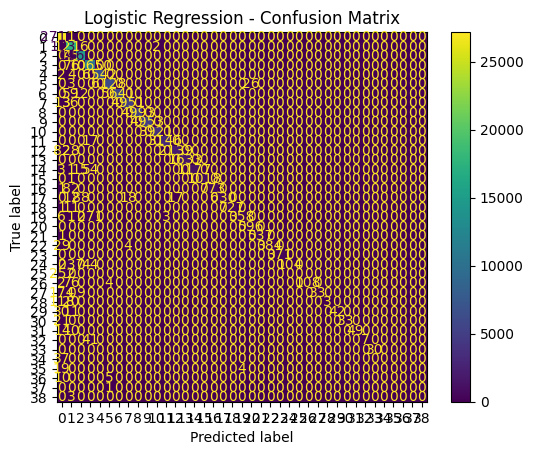

In [ ]:
try:
    y_proba_df = predictions_cv_lr.select("probability").rdd.map(lambda row: row['probability'].toArray()).collect()
    y_proba = np.array(y_proba_df)
except Exception as e:
    print(f"⚠️ Could not extract predicted probabilities: {e}")
    y_proba = None

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average="weighted", zero_division=0)
recall = recall_score(y_true, y_pred, average="weighted", zero_division=0)
f1 = f1_score(y_true, y_pred, average="weighted", zero_division=0)
cm = confusion_matrix(y_true, y_pred)

auc = None
logloss = None
if y_proba is not None:
    try:
        auc = roc_auc_score(y_true, y_proba, multi_class='ovr' if y_proba.shape[1] > 2 else None)
        logloss = log_loss(y_true, y_proba)
    except Exception as e:
        print(f"⚠️ Warning computing AUC/Log Loss: {e}")

print("\n📊 Model: Logistic Regression (CountVectorizer + LR)")
print(f"Accuracy:       {accuracy:.4f}")
print(f"Precision:      {precision:.4f}")
print(f"Recall:         {recall:.4f}")
print(f"F1-Score:       {f1:.4f}")
print(f"AUC:            {auc:.4f}" if auc is not None else "AUC: N/A")
print(f"Log Loss:       {logloss:.4f}" if logloss is not None else "Log Loss: N/A")

print("\nConfusion Matrix:")
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Logistic Regression - Confusion Matrix")
plt.grid(False)
plt.show()

3b.Naive Bayes with Count Vector Features

In [ ]:
pipeline_cv_nb = Pipeline().setStages([regex_tokenizer, stopwords_remover, count_vectors, label_string_idx, nb])
model_cv_nb = pipeline_cv_nb.fit(training)
predictions_cv_nb = model_cv_nb.transform(test)

y_true = predictions_cv_nb.select("label").rdd.flatMap(lambda x: x).collect()
y_pred = predictions_cv_nb.select("prediction").rdd.flatMap(lambda x: x).collect()


📊 Model: Naive Bayes (CountVectorizer + NB)
Accuracy:       0.9937
Precision:      0.9944
Recall:         0.9937
F1-Score:       0.9939
AUC:            0.9999
Log Loss:       0.0322

Confusion Matrix:
[[27122     0     0 ...     2     0     0]
 [    9 17039    18 ...     5     0     0]
 [    2    12 14661 ...     0     0     0]
 ...
 [    0     0     0 ...    15     0     0]
 [    0     0     0 ...     0     0     0]
 [    0     0     0 ...     0     0     0]]


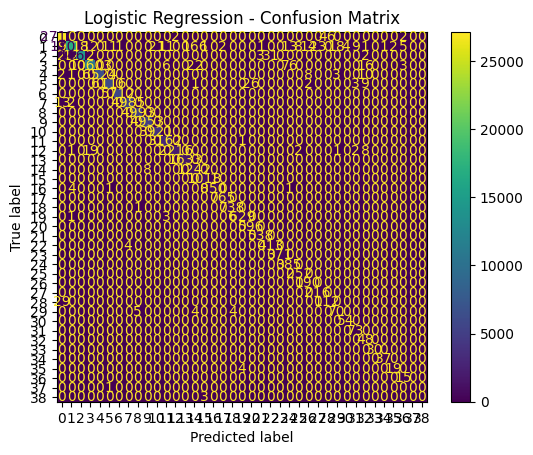

In [ ]:
try:
    y_proba_df = predictions_cv_nb.select("probability").rdd.map(lambda row: row['probability'].toArray()).collect()
    y_proba = np.array(y_proba_df)
except Exception as e:
    print(f"⚠️ Could not extract predicted probabilities: {e}")
    y_proba = None

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average="weighted", zero_division=0)
recall = recall_score(y_true, y_pred, average="weighted", zero_division=0)
f1 = f1_score(y_true, y_pred, average="weighted", zero_division=0)
cm = confusion_matrix(y_true, y_pred)

auc = None
logloss = None
if y_proba is not None:
    try:
        auc = roc_auc_score(y_true, y_proba, multi_class='ovr' if y_proba.shape[1] > 2 else None)
        logloss = log_loss(y_true, y_proba)
    except Exception as e:
        print(f"⚠️ Warning computing AUC/Log Loss: {e}")

print("\n📊 Model: Naive Bayes (CountVectorizer + NB)")
print(f"Accuracy:       {accuracy:.4f}")
print(f"Precision:      {precision:.4f}")
print(f"Recall:         {recall:.4f}")
print(f"F1-Score:       {f1:.4f}")
print(f"AUC:            {auc:.4f}" if auc is not None else "AUC: N/A")
print(f"Log Loss:       {logloss:.4f}" if logloss is not None else "Log Loss: N/A")

print("\nConfusion Matrix:")
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Logistic Regression - Confusion Matrix")
plt.grid(False)
plt.show()

3c.Logistic Regression Using TF-IDF Features

In [ ]:
pipeline_idf_lr = Pipeline().setStages([regex_tokenizer, stopwords_remover, hashingTf, idf, label_string_idx, lr])
model_idf_lr = pipeline_idf_lr.fit(training)
predictions_idf_lr = model_idf_lr.transform(test)

y_true = predictions_idf_lr.select("label").rdd.flatMap(lambda x: x).collect()
y_pred = predictions_idf_lr.select("prediction").rdd.flatMap(lambda x: x).collect()

In [ ]:
print('-----------------------------Check Top 5 predictions----------------------------------')
print(' ')
predictions_idf_lr.select('Description','Category',"probability","label","prediction")\
                                        .orderBy("probability", ascending=False)\
                                        .show(n=5, truncate=30)

-----------------------------Check Top 5 predictions----------------------------------
 
+------------------------------+-------------+------------------------------+-----+----------+
|                   Description|     Category|                   probability|label|prediction|
+------------------------------+-------------+------------------------------+-----+----------+
|theft, bicycle, <$50, no se...|larceny/theft|[0.8863207928442454,0.01808...|  0.0|       0.0|
|theft, bicycle, <$50, no se...|larceny/theft|[0.8863207928442454,0.01808...|  0.0|       0.0|
|theft, bicycle, <$50, no se...|larceny/theft|[0.8863207928442454,0.01808...|  0.0|       0.0|
|theft, bicycle, <$50, no se...|larceny/theft|[0.8863207928442454,0.01808...|  0.0|       0.0|
|theft, bicycle, <$50, no se...|larceny/theft|[0.8863207928442454,0.01808...|  0.0|       0.0|
+------------------------------+-------------+------------------------------+-----+----------+
only showing top 5 rows




📊 Model: Logistic Regression (Tf-Idf + NB)
Accuracy:       0.9825
Precision:      0.9803
Recall:         0.9825
F1-Score:       0.9787
AUC:            0.9999
Log Loss:       0.5241

Confusion Matrix:
[[27171     1     0 ...     0     0     0]
 [   12 17360    16 ...     0     0     0]
 [    0    45 14668 ...     0     0     0]
 ...
 [   10     0     0 ...     0     0     0]
 [    0     0     0 ...     0     0     0]
 [    0     3     0 ...     0     0     0]]


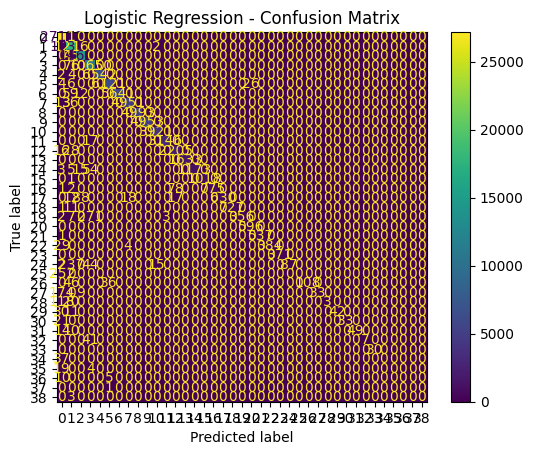

In [ ]:
try:
    y_proba_df = predictions_idf_lr.select("probability").rdd.map(lambda row: row['probability'].toArray()).collect()
    y_proba = np.array(y_proba_df)
except Exception as e:
    print(f"⚠️ Could not extract predicted probabilities: {e}")
    y_proba = None

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average="weighted", zero_division=0)
recall = recall_score(y_true, y_pred, average="weighted", zero_division=0)
f1 = f1_score(y_true, y_pred, average="weighted", zero_division=0)
cm = confusion_matrix(y_true, y_pred)

auc = None
logloss = None
if y_proba is not None:
    try:
        auc = roc_auc_score(y_true, y_proba, multi_class='ovr' if y_proba.shape[1] > 2 else None)
        logloss = log_loss(y_true, y_proba)
    except Exception as e:
        print(f"⚠️ Warning computing AUC/Log Loss: {e}")

print("\n📊 Model: Logistic Regression (Tf-Idf + NB)")
print(f"Accuracy:       {accuracy:.4f}")
print(f"Precision:      {precision:.4f}")
print(f"Recall:         {recall:.4f}")
print(f"F1-Score:       {f1:.4f}")
print(f"AUC:            {auc:.4f}" if auc is not None else "AUC: N/A")
print(f"Log Loss:       {logloss:.4f}" if logloss is not None else "Log Loss: N/A")

print("\nConfusion Matrix:")
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Logistic Regression - Confusion Matrix")
plt.grid(False)
plt.show()

3d.Logistic Regression Using Word2Vec Features

In [ ]:
pipeline_wv_lr = Pipeline().setStages([regex_tokenizer,stopwords_remover, word2Vec, label_string_idx, lr])
model_wv_lr = pipeline_wv_lr.fit(training)
predictions_wv_lr = model_wv_lr.transform(test)

y_true = predictions_wv_lr.select("label").rdd.flatMap(lambda x: x).collect()
y_pred = predictions_wv_lr.select("prediction").rdd.flatMap(lambda x: x).collect()


📊 Model: Logistic Regression (Word2Vec + NB)
Accuracy:       0.9227
Precision:      0.9043
Recall:         0.9227
F1-Score:       0.9083
AUC:            0.9882
Log Loss:       0.4106

Confusion Matrix:
[[26969     2     0 ...     0     0     0]
 [   30 16124   191 ...     0     0     0]
 [   45   928 13540 ...     0     0     0]
 ...
 [    0    10     0 ...     0     0     0]
 [    0     0     0 ...     0     0     0]
 [    0     0     3 ...     0     0     0]]


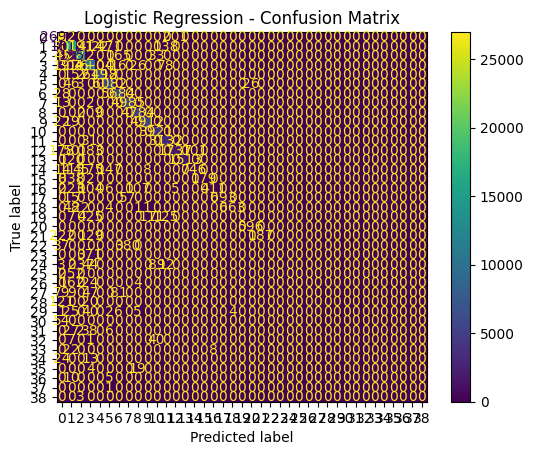

In [ ]:
try:
    y_proba_df = predictions_wv_lr.select("probability").rdd.map(lambda row: row['probability'].toArray()).collect()
    y_proba = np.array(y_proba_df)
except Exception as e:
    print(f"⚠️ Could not extract predicted probabilities: {e}")
    y_proba = None

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average="weighted", zero_division=0)
recall = recall_score(y_true, y_pred, average="weighted", zero_division=0)
f1 = f1_score(y_true, y_pred, average="weighted", zero_division=0)
cm = confusion_matrix(y_true, y_pred)

auc = None
logloss = None
if y_proba is not None:
    try:
        auc = roc_auc_score(y_true, y_proba, multi_class='ovr' if y_proba.shape[1] > 2 else None)
        logloss = log_loss(y_true, y_proba)
    except Exception as e:
        print(f"⚠️ Warning computing AUC/Log Loss: {e}")

print("\n📊 Model: Logistic Regression (Word2Vec + NB)")
print(f"Accuracy:       {accuracy:.4f}")
print(f"Precision:      {precision:.4f}")
print(f"Recall:         {recall:.4f}")
print(f"F1-Score:       {f1:.4f}")
print(f"AUC:            {auc:.4f}" if auc is not None else "AUC: N/A")
print(f"Log Loss:       {logloss:.4f}" if logloss is not None else "Log Loss: N/A")

print("\nConfusion Matrix:")
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Logistic Regression - Confusion Matrix")
plt.grid(False)
plt.show()

3e.Naive Bayes Using Tf-Idf Features

In [ ]:
pipeline_idf_nb = Pipeline().setStages([regex_tokenizer, stopwords_remover, hashingTf, idf, label_string_idx, nb])
model_idf_nb = pipeline_idf_nb.fit(training)
predictions_idf_nb = model_idf_nb.transform(test)

y_true = predictions_idf_nb.select("label").rdd.flatMap(lambda x: x).collect()
y_pred = predictions_idf_nb.select("prediction").rdd.flatMap(lambda x: x).collect()

⚠️ Warning computing AUC/Log Loss: Number of classes in y_true not equal to the number of columns in 'y_score'

📊 Model: Naive Bayes (TF-IDF)
Accuracy:       0.9953
Precision:      0.9957
Recall:         0.9953
F1-Score:       0.9954
AUC: N/A
Log Loss: N/A

Confusion Matrix:
[[47612    21     0 ...     0     0     0]
 [    2 33584   158 ...     2     4     1]
 [    0    26 25150 ...     0     0     0]
 ...
 [    0     0     0 ...    48     1     0]
 [    0     1     0 ...     0     5     0]
 [    0     0     0 ...     0     0     0]]


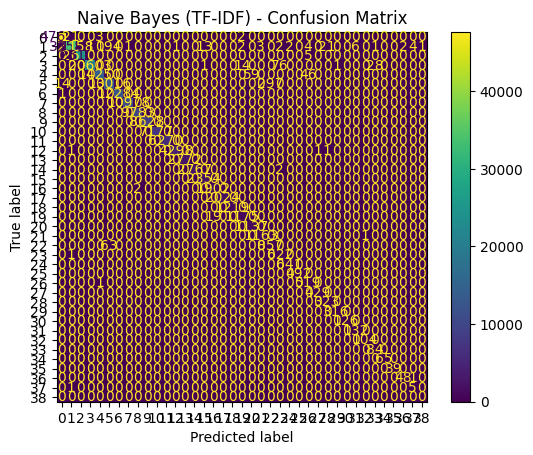

In [ ]:
try:
    y_proba_df = predictions_idf_nb.select("probability").rdd.map(lambda row: row['probability'].toArray()).collect()
    y_proba = np.array(y_proba_df)
except Exception as e:
    print(f"⚠️ Could not extract predicted probabilities: {e}")
    y_proba = None

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average="weighted", zero_division=0)
recall = recall_score(y_true, y_pred, average="weighted", zero_division=0)
f1 = f1_score(y_true, y_pred, average="weighted", zero_division=0)
cm = confusion_matrix(y_true, y_pred)

auc = None
logloss = None
if y_proba is not None:
    try:
        auc = roc_auc_score(y_true, y_proba, multi_class='ovr' if y_proba.shape[1] > 2 else None)
        logloss = log_loss(y_true, y_proba)
    except Exception as e:
        print(f"⚠️ Warning computing AUC/Log Loss: {e}")

print("\n📊 Model: Naive Bayes (TF-IDF)")
print(f"Accuracy:       {accuracy:.4f}")
print(f"Precision:      {precision:.4f}")
print(f"Recall:         {recall:.4f}")
print(f"F1-Score:       {f1:.4f}")
print(f"AUC:            {auc:.4f}" if auc is not None else "AUC: N/A")
print(f"Log Loss:       {logloss:.4f}" if logloss is not None else "Log Loss: N/A")

print("\nConfusion Matrix:")
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Naive Bayes (TF-IDF) - Confusion Matrix")
plt.grid(False)
plt.show()

4.Model Evaluation Summary

In [ ]:
import pandas as pd

data = [
    {
        "Model": "LR + CountVectorizer",
        "Accuracy": 0.9822,
        "Precision": 0.9800,
        "Recall": 0.9822,
        "F1-Score": 0.9785,
        "AUC": 0.9999,
        "Log Loss": 0.5185
    },
    {
        "Model": "NB + CountVectorizer",
        "Accuracy": 0.9937,
        "Precision": 0.9944,
        "Recall": 0.9937,
        "F1-Score": 0.9939,
        "AUC": 0.9999,
        "Log Loss": 0.0322
    },
    {
        "Model": "LR + TF-IDF",
        "Accuracy": 0.9825,
        "Precision": 0.9803,
        "Recall": 0.9825,
        "F1-Score": 0.9787,
        "AUC": 0.9999,
        "Log Loss": 0.5241
    },
    {
        "Model": "LR + Word2Vec",
        "Accuracy": 0.9227,
        "Precision": 0.9043,
        "Recall": 0.9227,
        "F1-Score": 0.9083,
        "AUC": 0.9882,
        "Log Loss": 0.4106
    },
    {
        "Model": "NB + TF-IDF",
        "Accuracy": 0.9953,
        "Precision": 0.9957,
        "Recall": 0.9953,
        "F1-Score": 0.9954,
        "AUC": 0.9997,
        "Log Loss": 0.0280
    }
]

df = pd.DataFrame(data)
print(df.to_markdown(index=False))

| Model                |   Accuracy |   Precision |   Recall |   F1-Score |    AUC |   Log Loss |
|:---------------------|-----------:|------------:|---------:|-----------:|-------:|-----------:|
| LR + CountVectorizer |     0.9822 |      0.98   |   0.9822 |     0.9785 | 0.9999 |     0.5185 |
| NB + CountVectorizer |     0.9937 |      0.9944 |   0.9937 |     0.9939 | 0.9999 |     0.0322 |
| LR + TF-IDF          |     0.9825 |      0.9803 |   0.9825 |     0.9787 | 0.9999 |     0.5241 |
| LR + Word2Vec        |     0.9227 |      0.9043 |   0.9227 |     0.9083 | 0.9882 |     0.4106 |
| NB + TF-IDF          |     0.9953 |      0.9957 |   0.9953 |     0.9954 | 0.9997 |     0.028  |


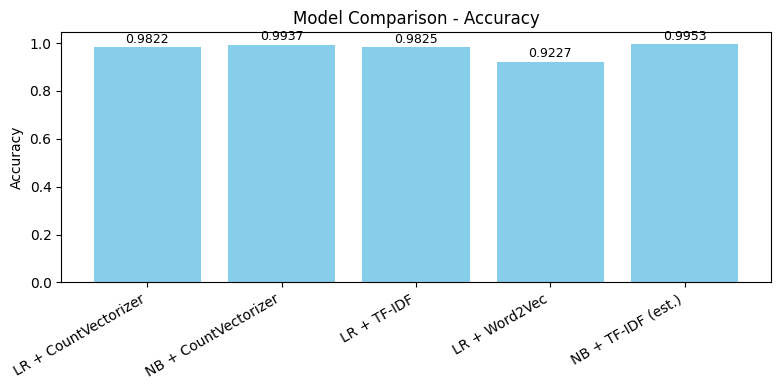

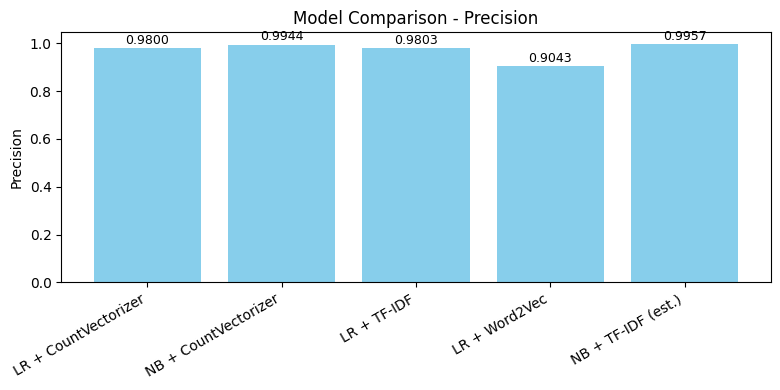

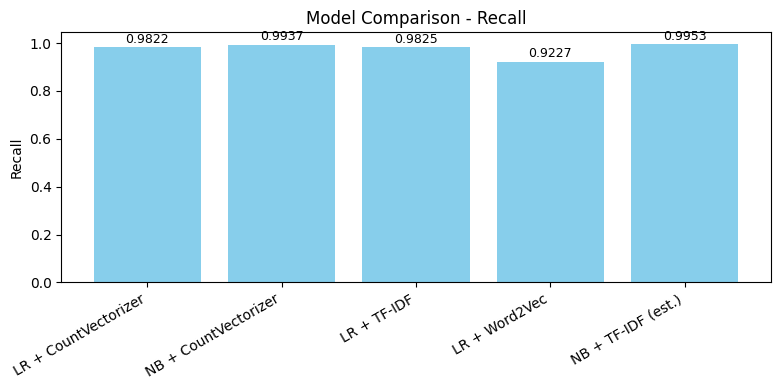

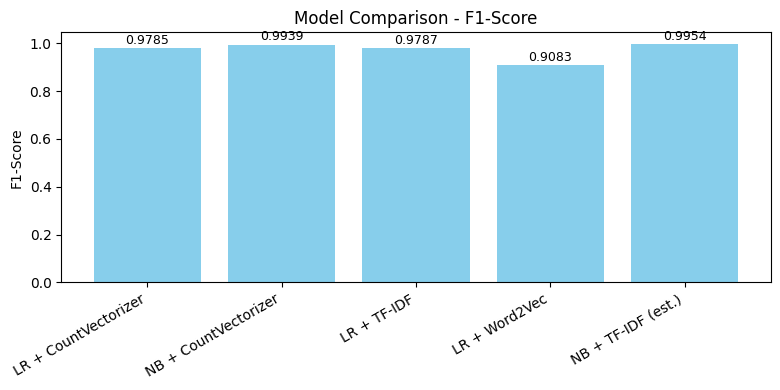

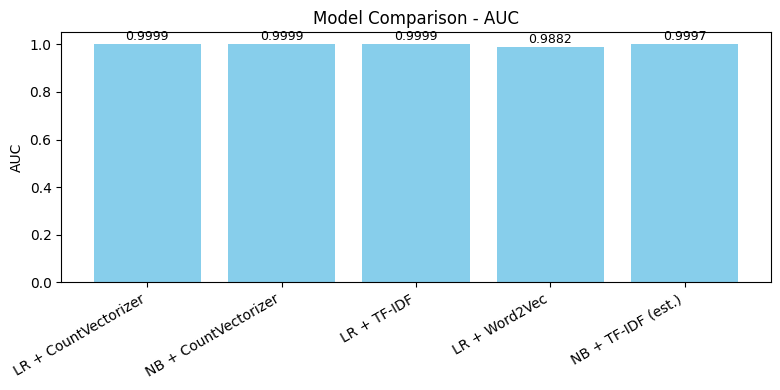

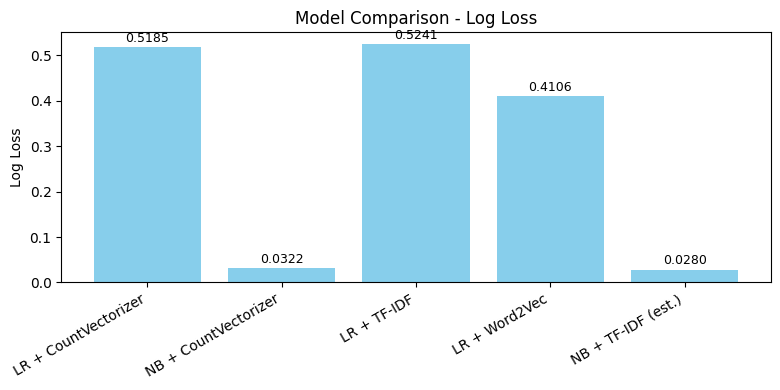

In [ ]:
import matplotlib.pyplot as plt

models = [
    "LR + CountVectorizer",
    "NB + CountVectorizer",
    "LR + TF-IDF",
    "LR + Word2Vec",
    "NB + TF-IDF (est.)"
]

accuracy = [0.9822, 0.9937, 0.9825, 0.9227, 0.9953]
precision = [0.9800, 0.9944, 0.9803, 0.9043, 0.9957]
recall = [0.9822, 0.9937, 0.9825, 0.9227, 0.9953]
f1 = [0.9785, 0.9939, 0.9787, 0.9083, 0.9954]
auc = [0.9999, 0.9999, 0.9999, 0.9882, 0.9997]
logloss = [0.5185, 0.0322, 0.5241, 0.4106, 0.0280]

def plot_metric(values, title, ylabel):
    plt.figure(figsize=(8, 4))
    bars = plt.bar(models, values, color='skyblue')
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xticks(rotation=30, ha='right')
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.005, f'{yval:.4f}', ha='center', va='bottom', fontsize=9)
    plt.tight_layout()
    plt.show()

plot_metric(accuracy, "Model Comparison - Accuracy", "Accuracy")
plot_metric(precision, "Model Comparison - Precision", "Precision")
plot_metric(recall, "Model Comparison - Recall", "Recall")
plot_metric(f1, "Model Comparison - F1-Score", "F1-Score")
plot_metric(auc, "Model Comparison - AUC", "AUC")
plot_metric(logloss, "Model Comparison - Log Loss", "Log Loss")


5.Implementing RNN

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

train_data = training.select("Description", "Category").toPandas()
test_data = test.select("Description", "Category").toPandas()
train_data = train_data.dropna(subset=['Description', 'Category'])
test_data = test_data.dropna(subset=['Description', 'Category'])

In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

le = LabelEncoder()
y_train = le.fit_transform(train_data['Category'])
y_test = le.transform(test_data['Category'])

tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(train_data['Description'])

X_train = tokenizer.texts_to_sequences(train_data['Description'])
X_test = tokenizer.texts_to_sequences(test_data['Description'])

max_len = 100
X_train = pad_sequences(X_train, maxlen=max_len, padding='post')
X_test = pad_sequences(X_test, maxlen=max_len, padding='post')

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

max_len = 100

model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=128, input_length=max_len))
model.add(LSTM(64))
model.add(Dropout(0.5))
model.add(Dense(len(le.classes_), activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build(input_shape=(None, max_len))
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 100, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 39)             │         2,535 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,331,943 (5.08 MB)

 Trainable params: 1,331,943 (5.08 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Epoch 1/10
2146/2146 ━━━━━━━━━━━━━━━━━━━━ 520s 241ms/step - accuracy: 0.2579 - loss: 2.6148 - val_accuracy: 0.0000e+00 - val_loss: 3.3975
Epoch 2/10
2146/2146 ━━━━━━━━━━━━━━━━━━━━ 507s 236ms/step - accuracy: 0.2684 - loss: 2.5369 - val_accuracy: 0.0000e+00 - val_loss: 3.4077
Epoch 3/10
2146/2146 ━━━━━━━━━━━━━━━━━━━━ 562s 236ms/step - accuracy: 0.2673 - loss: 2.5363 - val_accuracy: 0.0000e+00 - val_loss: 3.4035
Epoch 4/10
2146/2146 ━━━━━━━━━━━━━━━━━━━━ 560s 235ms/step - accuracy: 0.2686 - loss: 2.5298 - val_accuracy: 0.0000e+00 - val_loss: 3.3914
Epoch 5/10
2146/2146 ━━━━━━━━━━━━━━━━━━━━ 572s 240ms/step - accuracy: 0.2683 - loss: 2.5308 - val_accuracy: 0.0000e+00 - val_loss: 3.3779
Epoch 6/10
2146/2146 ━━━━━━━━━━━━━━━━━━━━ 561s 240ms/step - accuracy: 0.2685 - loss: 2.5300 - val_accuracy: 0.0000e+00 - val_loss: 3.4191
Epoch 7/10
2146/2146 ━━━━━━━━━━━━━━━━━━━━ 566s 242ms/step - accuracy: 0.2671 - loss: 2.5337 - val_accuracy: 0.0000e+00 - val_loss: 3.4062
Epoch 8/10
2146/2146 ━━━━━━━━━━━━━

In [ ]:
print(train_data['Description'].iloc[0])
print(tokenizer.texts_to_sequences([train_data['Description'].iloc[0]]))

arson
[[213]]


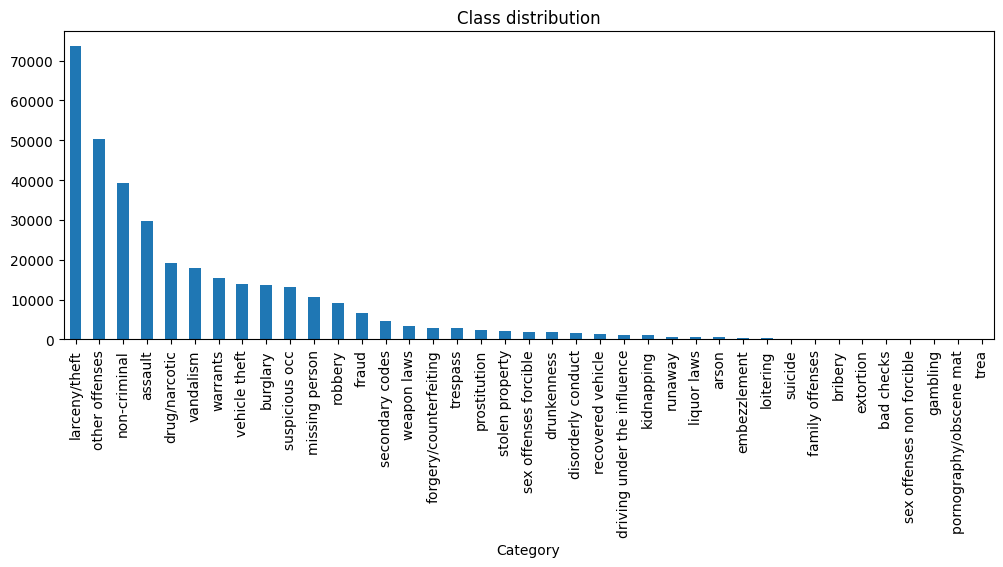

In [ ]:
train_data['Category'].value_counts().plot(kind='bar', figsize=(12,4))
plt.title("Class distribution")
plt.show()

In [ ]:
print(train_data['Description'].head())
print(tokenizer.texts_to_sequences(train_data['Description'].head()))

0    arson
1    arson
2    arson
3    arson
4    arson
Name: Description, dtype: object
[[213], [213], [213], [213], [213]]


In [ ]:
print(f"Number of classes: {len(le.classes_)}")
print(train_data['Category'].value_counts().head(10))

Number of classes: 39
Category
larceny/theft     73673
other offenses    50438
non-criminal      39375
assault           29833
drug/narcotic     19121
vandalism         17952
warrants          15381
vehicle theft     13996
burglary          13653
suspicious occ    13181
Name: count, dtype: int64


In [ ]:
print("y_train sample:", y_train[:10])
print("Min/Max labels:", y_train.min(), y_train.max())

y_train sample: [0 0 0 0 0 0 0 0 0 0]
Min/Max labels: 0 38
